Using device: cpu
Classes found: ['bleached_corals', 'healthy_corals']
Total images: 923
Training samples: 738
Validation samples: 185


C:\Users\hando\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hando\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\hando/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|███████████████████████████████████████████████████████████| 97.8M/97.8M [00:05<00:00, 18.8MB/s]


Epoch 1/20
----------
train Loss: 0.2568 Acc: 0.6436
val Loss: 2.1064 Acc: 0.5892

Epoch 2/20
----------
train Loss: 0.1834 Acc: 0.6612
val Loss: 0.2426 Acc: 0.7838

Epoch 3/20
----------
train Loss: 0.1318 Acc: 0.7547
val Loss: 0.1128 Acc: 0.8000

Epoch 4/20
----------
train Loss: 0.1222 Acc: 0.7818
val Loss: 0.0972 Acc: 0.8595

Epoch 5/20
----------
train Loss: 0.1241 Acc: 0.7710
val Loss: 0.1261 Acc: 0.8000

Epoch 6/20
----------
train Loss: 0.1216 Acc: 0.7642
val Loss: 0.1088 Acc: 0.7730

Epoch 7/20
----------
train Loss: 0.1153 Acc: 0.8049
val Loss: 0.1004 Acc: 0.8486

Epoch 8/20
----------
train Loss: 0.1064 Acc: 0.7995
val Loss: 0.1072 Acc: 0.8054

Epoch 9/20
----------
train Loss: 0.0957 Acc: 0.8320
val Loss: 0.1021 Acc: 0.8432

Epoch 10/20
----------
train Loss: 0.0890 Acc: 0.8577
val Loss: 0.2066 Acc: 0.7459

Epoch 11/20
----------
train Loss: 0.0895 Acc: 0.8482
val Loss: 0.1049 Acc: 0.8054

Epoch 12/20
----------
train Loss: 0.0800 Acc: 0.8726
val Loss: 0.1006 Acc: 0.8216

E

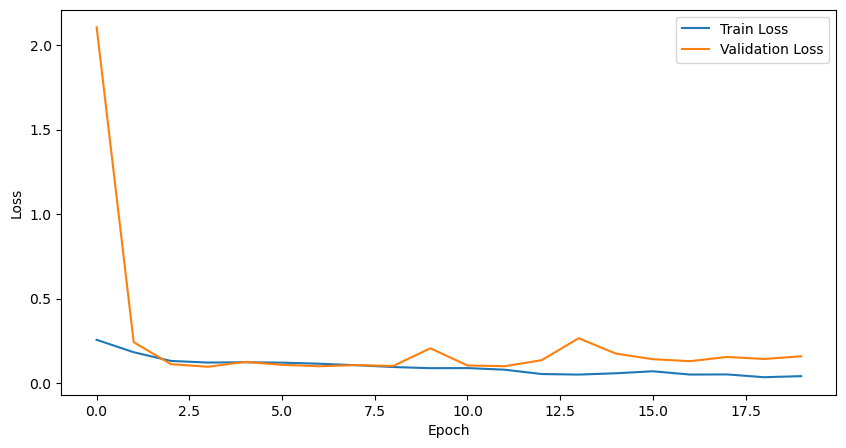

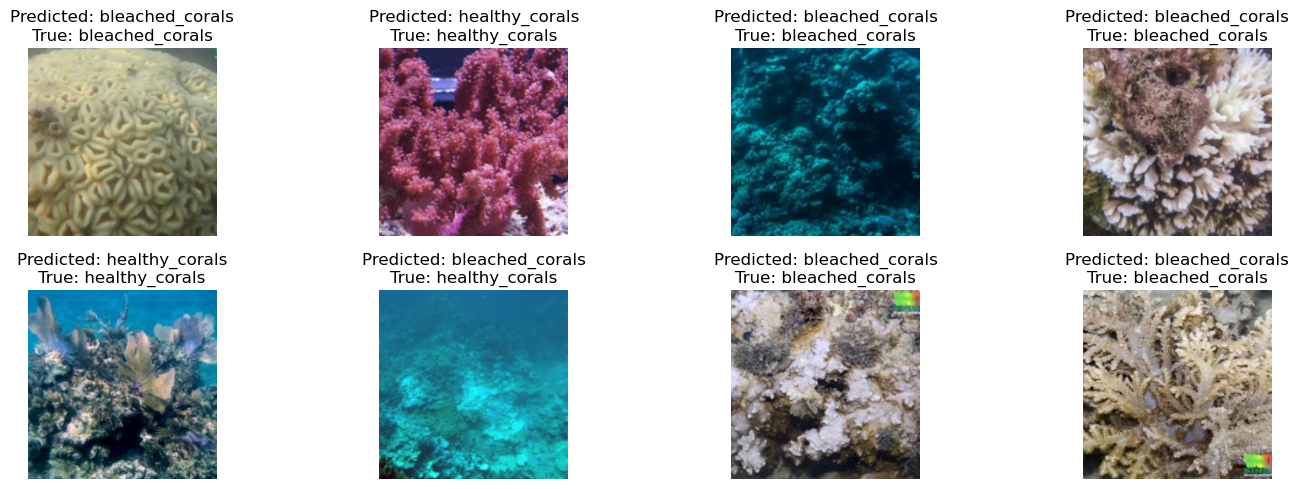

In [9]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix

# Check for available device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# 1. Data Preprocessing and Loading
# -------------------------------
# Update this variable with your local dataset path.
data_dir = r"C:\Users\hando\OneDrive\Desktop\coral_health_data"

# Folder structure should be:
# coral_health_data/
#   bleached_corals/    --> images of bleached corals
#   healthy_corals/     --> images of healthy corals

# Define enhanced data transformations.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Instead of simple Resize
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),  # More standardized crop for validation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

# Load the dataset using ImageFolder.
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])
print("Classes found:", full_dataset.classes)

# Split into training (80%) and validation (20%) sets.
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print("Total images:", len(full_dataset))
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# When setting up DataLoaders, we'll use the training transform for training and validation transform for validation.
# To do so, override the transform in the val_dataset:
val_dataset.dataset.transform = data_transforms['val']

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# -------------------------------
# 2. Model Architecture: Transfer Learning with ResNet50
# -------------------------------
# Use ResNet50 as a more powerful backbone.
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: bleached and healthy
model = model.to(device)

# -------------------------------
# 2.1 Define Focal Loss (for harder example focus)
# -------------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction='none')
        
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

criterion = FocalLoss(gamma=2)

# Define optimizer and scheduler.
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# -------------------------------
# 3. Training and Validation Functions
# -------------------------------
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
                loader = train_loader
            else:
                model.eval()   # Evaluation mode
                loader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches.
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()  # Zero the parameter gradients
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model if validation accuracy improves.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Step the scheduler after each epoch.
        scheduler.step()
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # Load best model weights.
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

# Train the model (increased epochs for better convergence).
num_epochs = 20
model, train_loss_history, val_loss_history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs)

# -------------------------------
# 4. Model Evaluation
# -------------------------------
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

true_labels, predictions = evaluate_model(model, val_loader)

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=full_dataset.classes))

print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))

# Plot training and validation loss over epochs.
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -------------------------------
# 5. Visualizing Sample Predictions
# -------------------------------
def imshow(inp, title=None):
    """Display a tensor as an image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of validation data and show predictions.
model.eval()
inputs, labels = next(iter(val_loader))
inputs = inputs.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)
inputs = inputs.cpu()  # For visualization

plt.figure(figsize=(15, 5))
for i in range(8):  # Show first 8 images.
    ax = plt.subplot(2, 4, i + 1)
    imshow(inputs[i])
    ax.set_title("Predicted: {}\nTrue: {}".format(full_dataset.classes[preds[i]], full_dataset.classes[labels[i]]))
plt.tight_layout()
plt.show()
